<a href="https://colab.research.google.com/github/Ravi10048/MNIST-using-CNN/blob/main/mnst_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.cuda
print(torch.cuda.is_available())

True


3
Epoch 1/100, Tr Loss: 1.2261, Tr Acc: 60.5300, Val Loss: 0.3316, Val Acc: 89.8200


KeyboardInterrupt: ignored

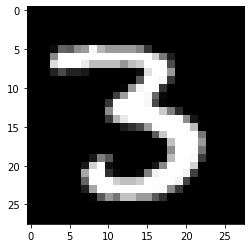

In [ ]:

import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
import torch.nn.functional as F

'''Create the Dataloder'''
# Mean and standard deviation of all the pixels in the MNIST dataset
mean_gray = 0.1307
stddev_gray = 0.3081

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((mean_gray,), (stddev_gray,))]) # grayscale has 1 mean_gray wheras color has 3

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_valid = datasets.MNIST('./data', train=False, download=True, transform=transform)
'''whenever the new image will get download it will first convert to tensor then normalize'''

img = mnist_train[12][0].numpy() * stddev_gray + mean_gray
plt.imshow(img.reshape(28, 28), cmap='gray') #converting tensor to numpy
# plt.show()
# Note that each image is 28 x 28 pixe

label = mnist_train[12][1]
print(label) #3
batch_size = 1024 # Reduce this if you get out-of-memory error
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=1)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, shuffle=True, num_workers=1)

class MNISTNet(nn.Module): #The CNN model is defined in the MNISTNet class, which consists of two convolutional layers and two fully connected layers.
    
    def __init__(self):
        super().__init__()
               
        # NOTE: All Conv2d layers have a default padding of 0 and stride of 1,
        # which is what we are using.
        
        # Convolution Layer 1                             # 28 x 28 x 1  (input)
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)      # 24 x 24 x 20  (after 1st convolution)
        self.relu1 = nn.ReLU()                            # Same as above
        
        # Convolution Layer 2
        self.conv2 = nn.Conv2d(20, 30, kernel_size=5)     # 20 x 20 x 30  (after 2nd convolution)
        self.conv2_drop = nn.Dropout2d(p=0.5)             # Same as above
        self.maxpool2 = nn.MaxPool2d(2)                   # 10 x 10 x 30  (after pooling)
        self.relu2 = nn.ReLU()                            # Same as above 
        
        # Fully connected layers
        self.fc1 = nn.Linear(3000, 500)  # 10 *10*30 output of above and input for this
        self.fc2 = nn.Linear(500, 10)  # specify no. of class label

    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                        
        x = self.relu1(x)                        
        
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        
        # Switch from activation maps to vectors
        x = x.view(-1, 3000)
        
        # Fully connected layer 1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=True)
        
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x
    

# Create the objects
if __name__ == '__main__':
    torch.multiprocessing.freeze_support()
    # The model
    net = MNISTNet()

    if cuda.is_available():
        net = net.cuda()

    # Our loss function
    criterion = nn.CrossEntropyLoss()

    # Our optimizer
    learning_rate = 0.01
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 

    '''Training loop'''

    num_epochs = 100 #100

    train_loss = []
    valid_loss = []
    train_accuracy = []
    valid_accuracy = []


    for epoch in range(num_epochs):
        
        ############################
        # Train
        ############################
        iter_loss = 0.0
        correct = 0
        iterations = 0
        
        net.train()                   # Put the network into training mode by each iteration
        
        for i, (items, classes) in enumerate(mnist_train_loader):
            
            # Convert torch tensor to Variable
            items = Variable(items)
            classes = Variable(classes)
            
            # If we have GPU, shift the data to GPU
            if cuda.is_available():
                items = items.cuda()
                classes = classes.cuda()
            
            optimizer.zero_grad()     # Clear off the gradients from any past operation
            outputs = net(items)      # Do the forward pass
            loss = criterion(outputs, classes) # Calculate the loss
            iter_loss += loss.item() # Accumulate the loss
            loss.backward()           # Calculate the gradients with help of back propagation
            optimizer.step()          # Ask the optimizer to adjust the parameters based on the gradients
            
            # Record the correct predictions for training data 
            _, predicted = torch.max(outputs.data, 1)
            if torch.cuda.is_available():
                 correct += (predicted.cpu() == classes.data.cpu()).sum().item()
            else:
                correct += (predicted == classes.data).sum().item()
            # correct += (predicted == classes.data).sum()
            iterations += 1
        
        # Record the training loss
        train_loss.append(iter_loss/iterations)
        # Record the training accuracy
        train_accuracy.append((100 * correct / len(mnist_train_loader.dataset)))
    

        ############################
        # Validate - How did we do on the unseen dataset?
        ############################
        
        loss = 0.0
        correct = 0
        iterations = 0

        net.eval()                    # Put the network into evaluate mode optimizer stop
        
        for i, (items, classes) in enumerate(mnist_valid_loader):
            
            # Convert torch tensor to Variable
            items = Variable(items)
            classes = Variable(classes)
            
            # If we have GPU, shift the data to GPU
            if cuda.is_available():
                items = items.cuda()
                classes = classes.cuda()
            
            outputs = net(items)      # Do the forward pass
            loss += criterion(outputs, classes).item() # Calculate the loss
            
            # Record the correct predictions for training data
            _, predicted = torch.max(outputs.data, 1)
            if torch.cuda.is_available():
                 correct += (predicted.cpu() == classes.data.cpu()).sum().item()
            else:
                correct += (predicted == classes.data).sum().item()
            # correct += (predicted == classes.data).sum()
            
            iterations += 1

        # Record the validation loss
        valid_loss.append(loss/iterations)
        # Record the validation accuracy
        valid_accuracy.append(correct / len(mnist_valid_loader.dataset) * 100.0)

        
        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f'
            %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], 
                valid_loss[-1], valid_accuracy[-1]))
        
    # Loss
   
    f = plt.figure(figsize=(10, 8))
    plt.plot(train_loss, label='training loss')
    plt.plot(valid_loss, label='validation loss')
    plt.legend()
    plt.show()


    # Accuracy
    # # if using cuda
   
    import numpy as np
    f = plt.figure(figsize=(10, 8))
    # # if using cuda
    plt.plot(np.array(train_accuracy), label='training accuracy')
    plt.plot(np.array(valid_accuracy), label='validation accuracy')
    # else
    # plt.plot(train_accuracy, label='training accuracy')
    # plt.plot(valid_accuracy, label='validation accuracy')
    plt.legend()
    plt.show()


    torch.save(net.state_dict(), "./mnist.model.pth")
net=MNISTNet()
net.load_state_dict(torch.load("./mnist.model.pth"))
        
'''Standalone inference'''

image_index = 23
img = mnist_valid[image_index][0].resize_((1, 1, 28, 28))
img = Variable(img)
label = mnist_valid[image_index][1]

net.eval()

if cuda.is_available():
    net = net.cuda()
    img = img.cuda()
else:
    net = net.cpu()
    img = img.cpu()
    
output = net(img)

print(output.data)

_, predicted = torch.max(output.data, 1)
print("Prediction is: ", predicted)

print("Actual is is: ", label)